/home/poti/Documents/Faks/Letnik_4/IS/IAN4


/tmp/ipykernel_10462/3288290845.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p[0].show()


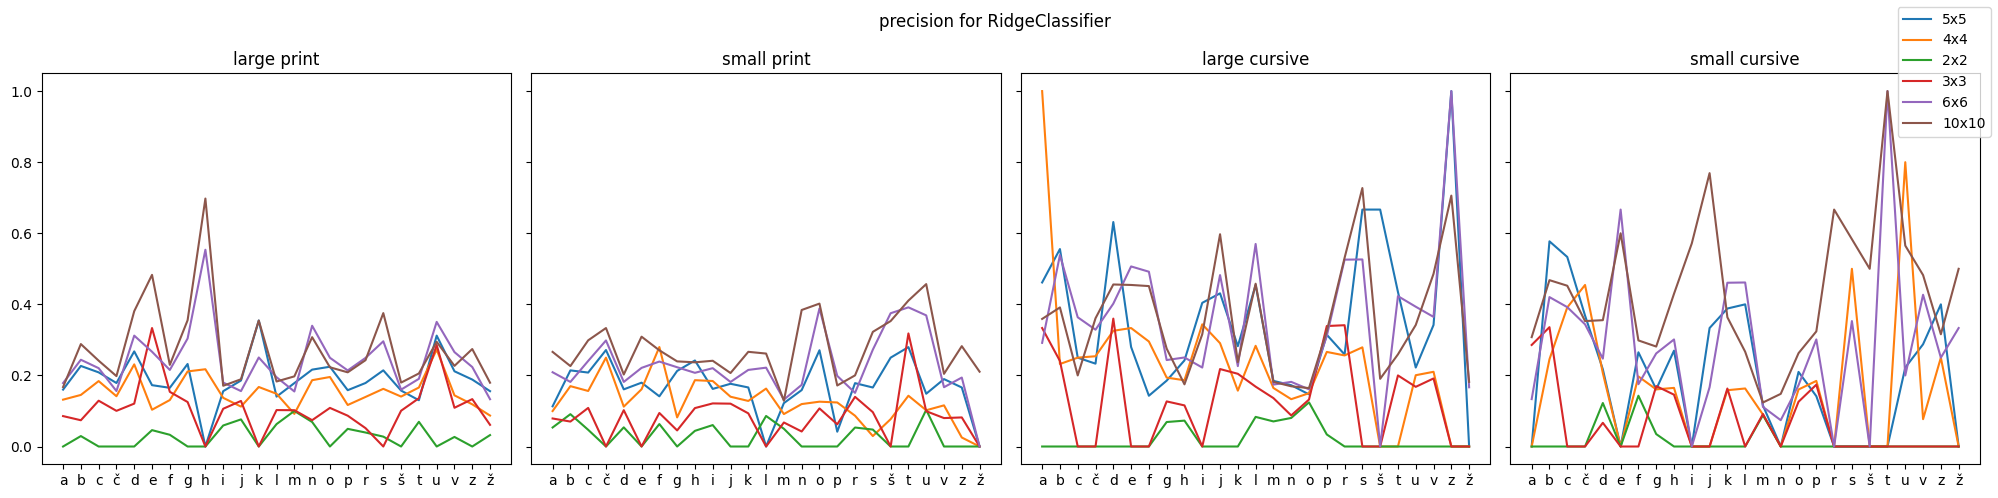

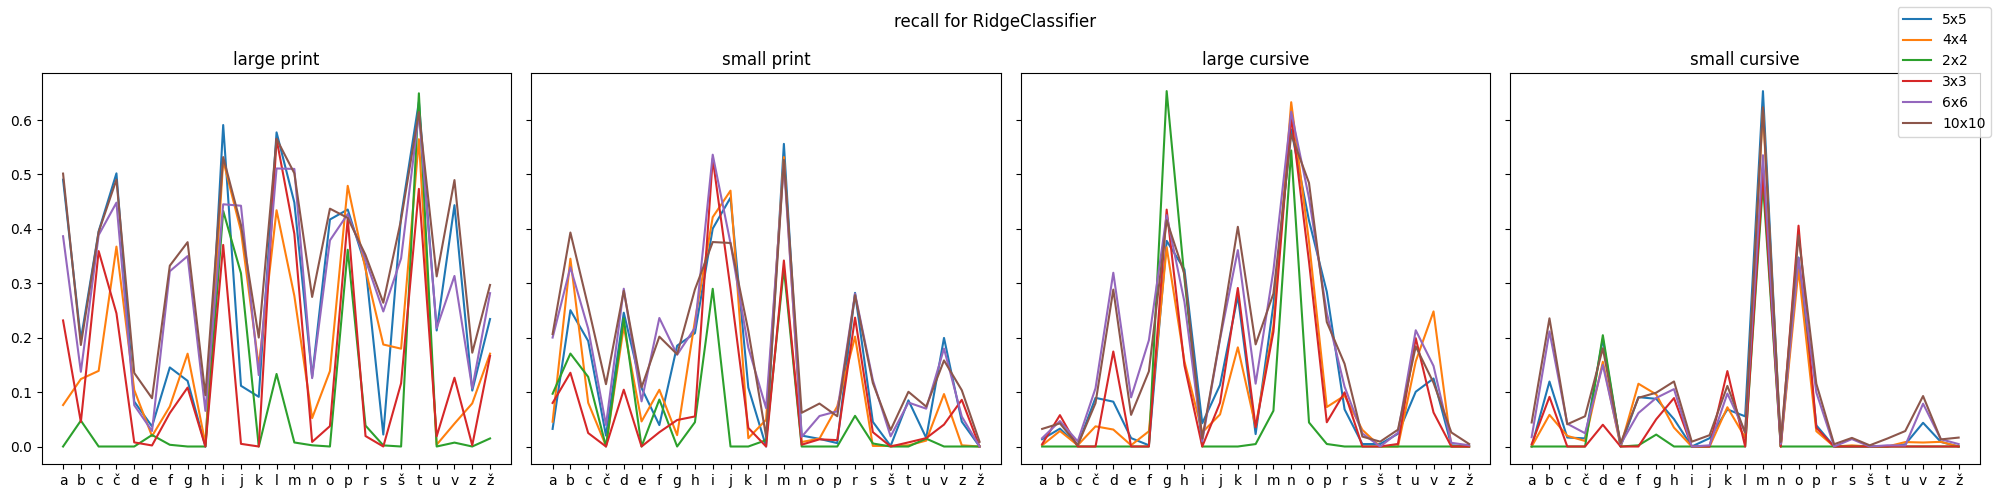

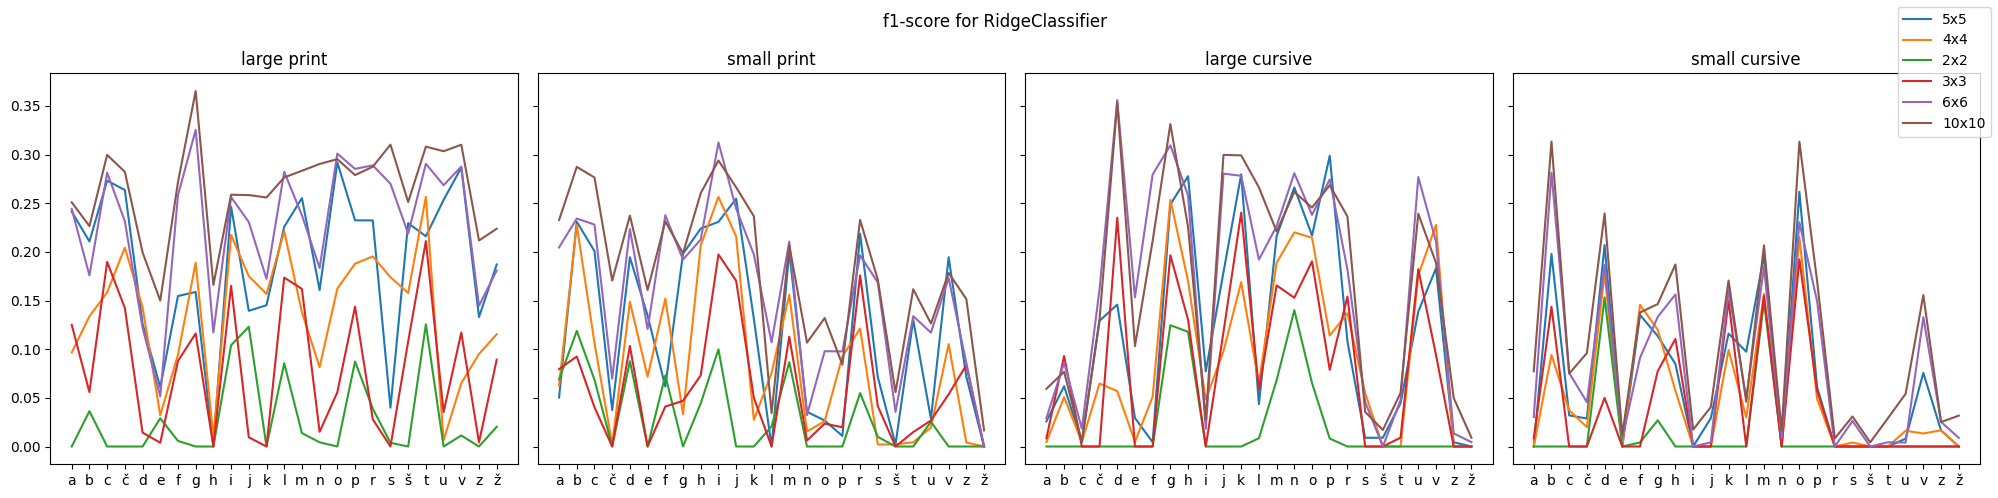

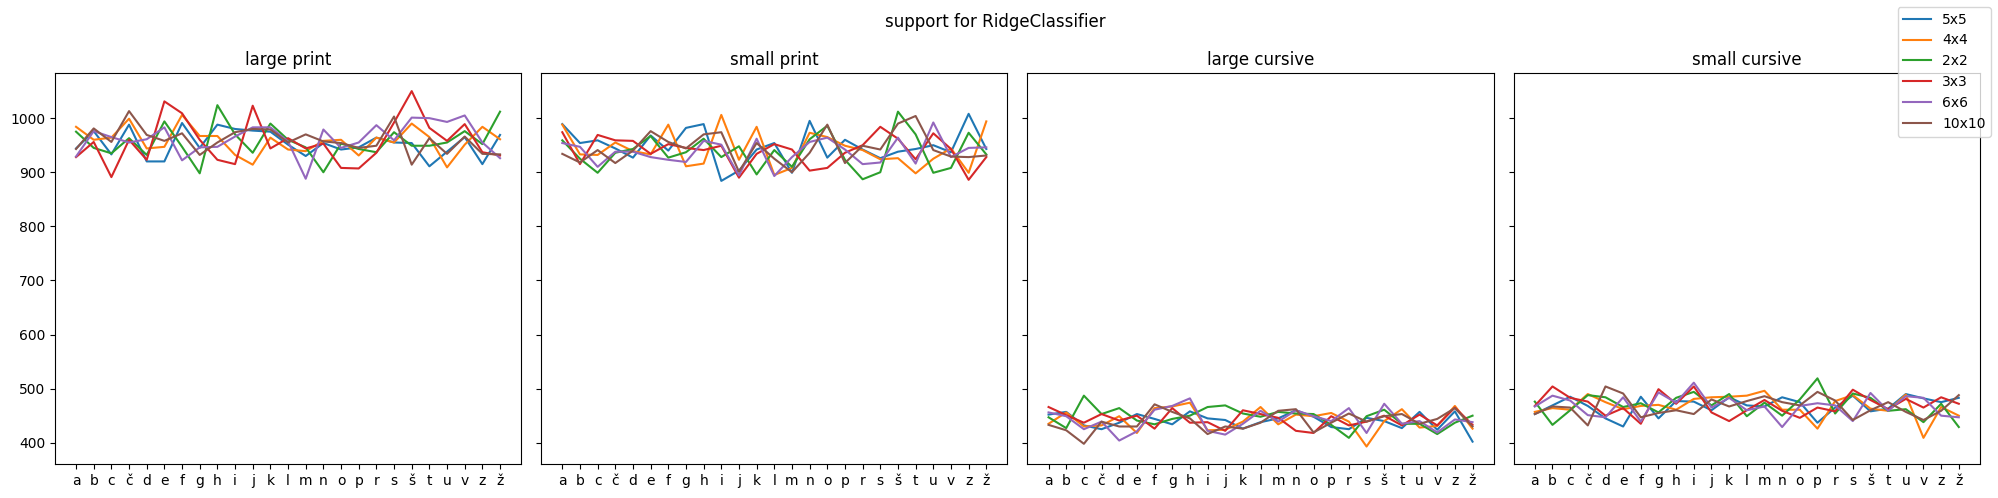

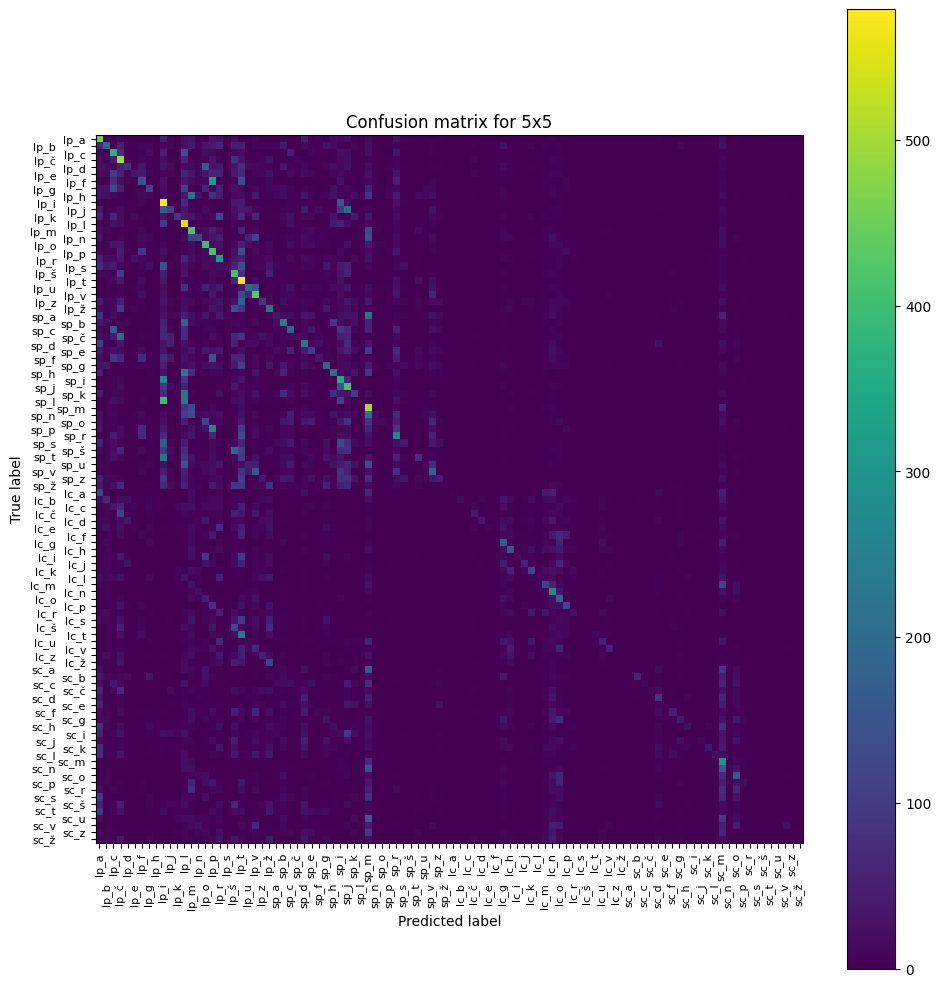

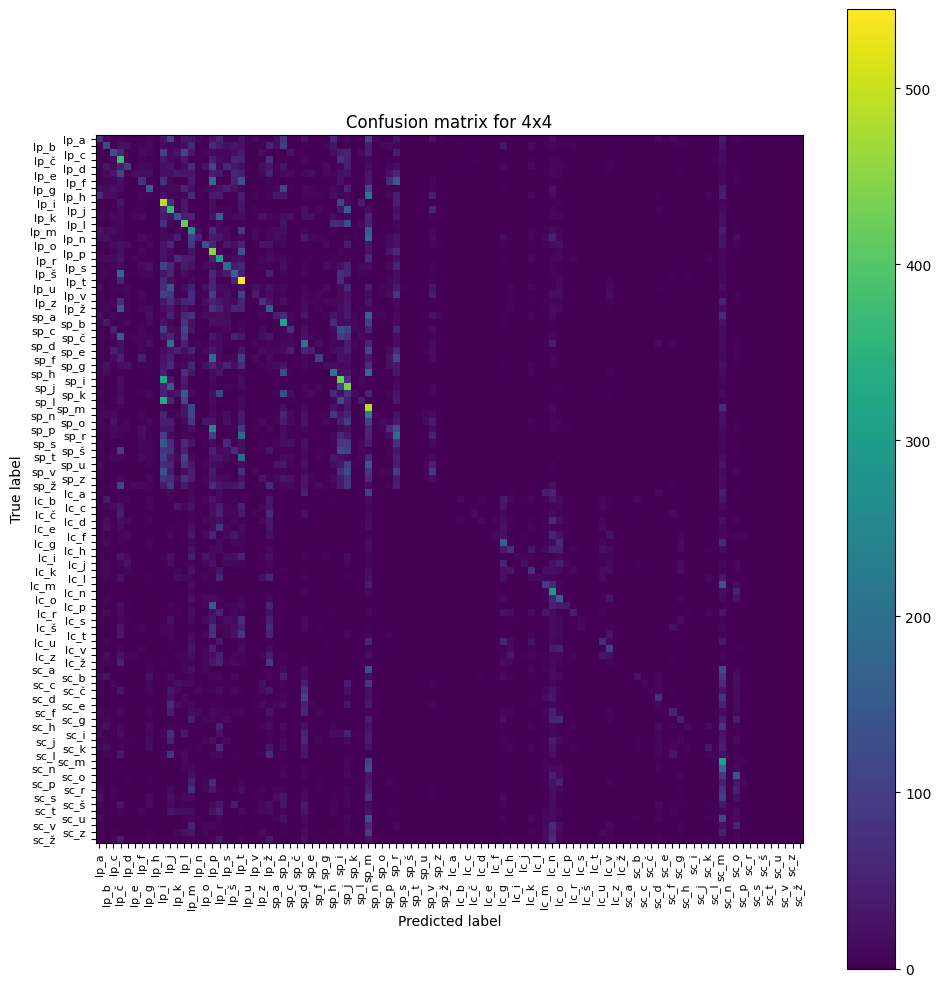

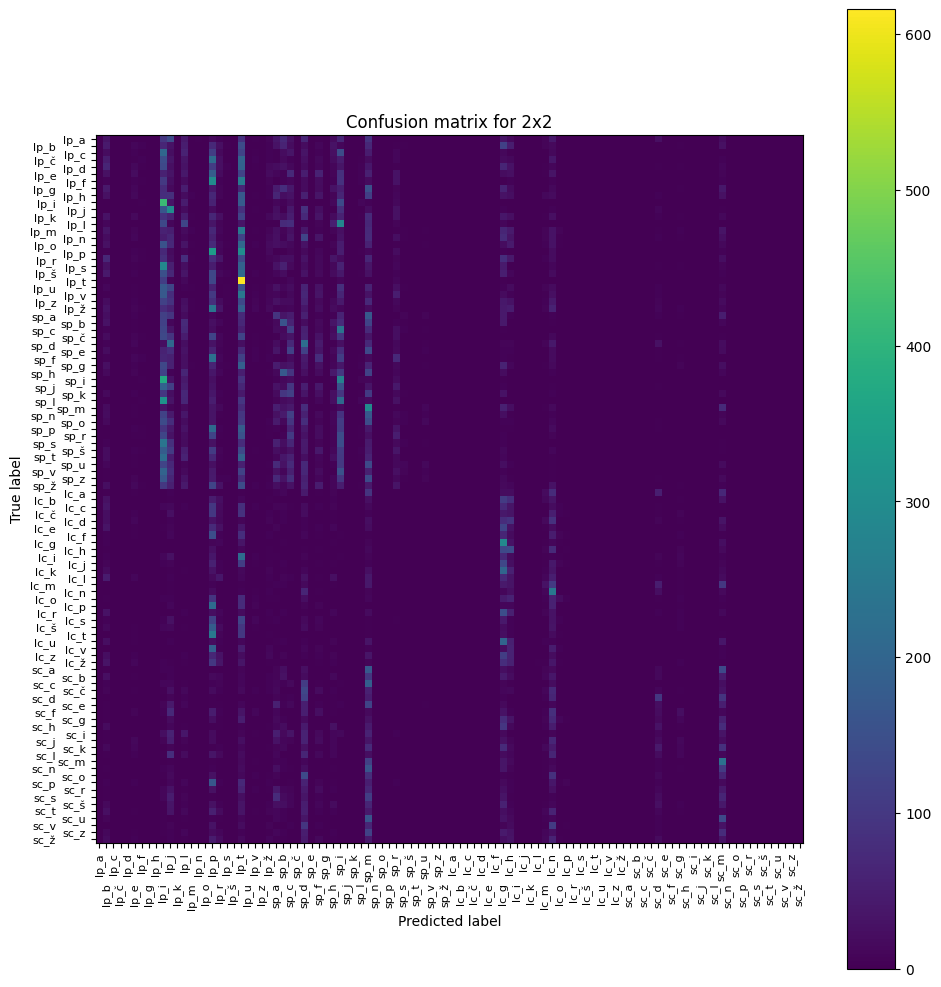

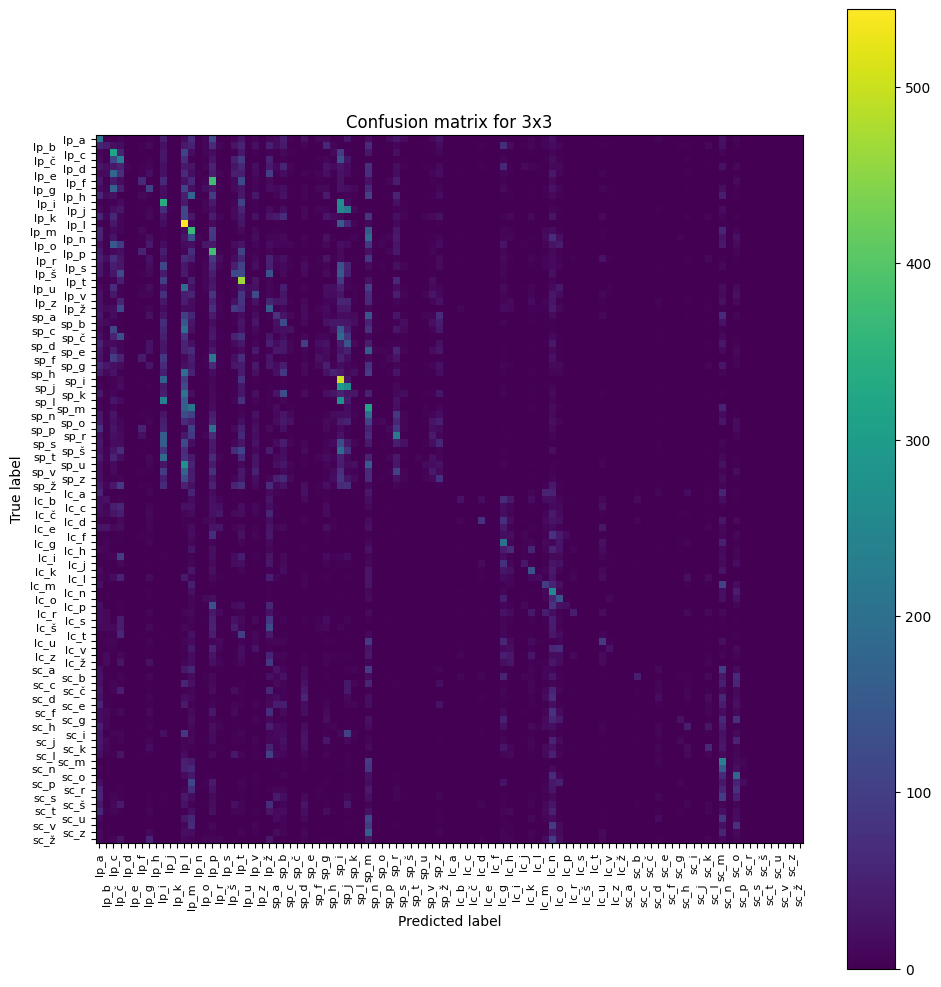

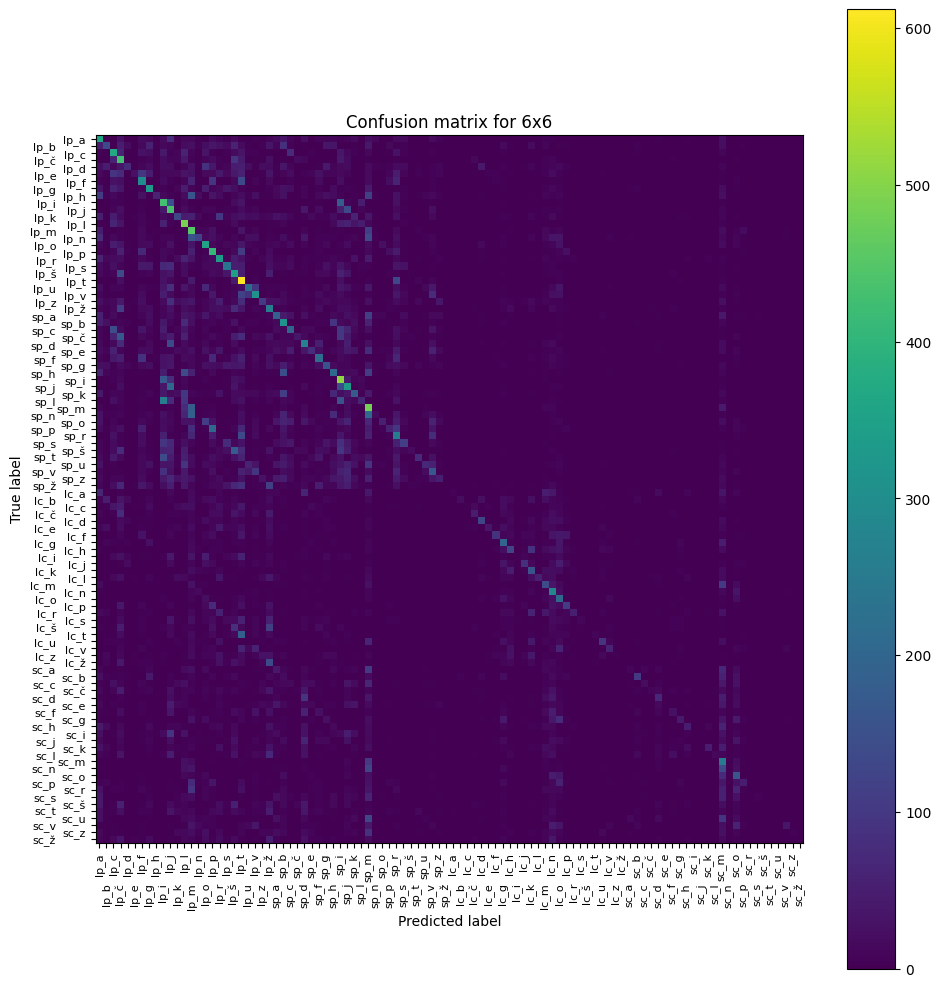

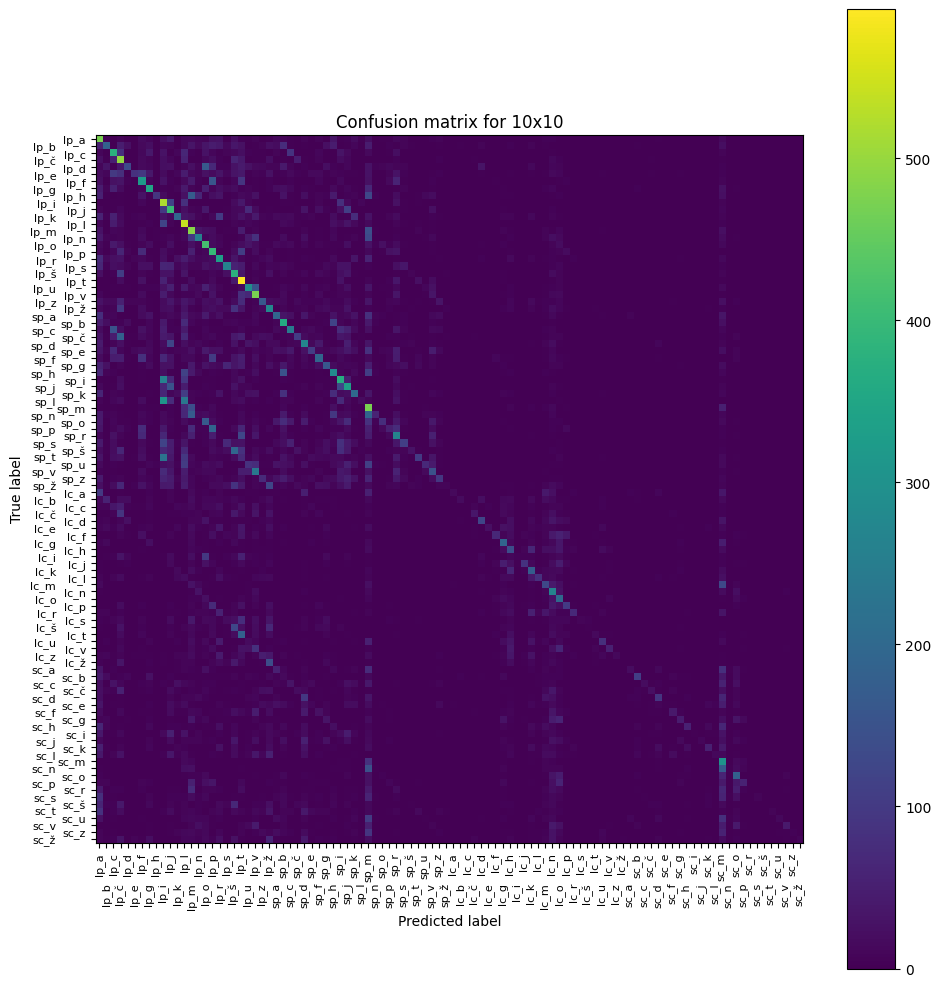

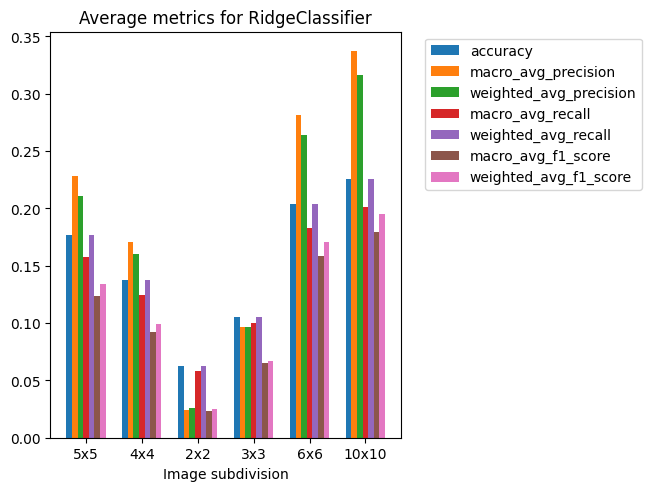

In [54]:
from matplotlib.pyplot import tight_layout
from typing_extensions import Literal
%cd .
import glob
import re
import json
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


tag_map = json.load(open("database/tag_map.json"))
tags = list(map(lambda x : x[0], sorted(tag_map.items(), key=lambda x: x[1])))

def prefix_to_name(prefix: str):
    match prefix:
        case 'lp':
            return 'large print'
        case 'sp':
            return 'small print'
        case 'lc':
            return 'large cursive'
        case 'sc':
            return 'small cursive'
        case _:
            raise ValueError(f"Invalid prefix: {prefix}")


def plot_per_label_stat(dat, stat, ax, label, plot_tags=tags):    
    c_rep = dat['classification_report']
    vals = []
    for tag in plot_tags:
        val = c_rep[str(tag_map[tag])][stat]
        vals.append(val)
    
    ax.plot([t.split('_')[1] for t in plot_tags], vals, label=label)
    
def plot_confusion_matrix(n, dat):
    c_mat = np.array(dat['confusion_matrix'])
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), tight_layout=True)
    ax.tick_params(axis='both', labelsize=8)
    mat = ConfusionMatrixDisplay(c_mat, display_labels=tags)
    ax.set_title(f"Confusion matrix for {n}x{n}")
    mat.plot(include_values=False, xticks_rotation='vertical', ax=ax)
    for t in ax.xaxis.get_major_ticks()[1::2]:
        t.set_pad(25)    
    for t in ax.yaxis.get_major_ticks()[1::2]:
        t.set_pad(25)
    plt.show()
    
def grouped_bar_chart(sets, data, width = 0.25):
    x = np.arange(len(sets))  # the label locations
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')
    
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        # ax.bar_label(rects, padding=3)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xticks(x + width * (len(data) // 2), sets)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        

def plot_stats_single(model_name, res_dir="results", t: Literal['cv', 'hyper', '*'] = 'cv'):
    files = {}
    labels = []
    avg_stats = {
        "accuracy": [],
        "macro_avg_precision": [],
        "weighted_avg_precision": [],
        "macro_avg_recall": [],
        "weighted_avg_recall": [],
        "macro_avg_f1_score": [],   
        "weighted_avg_f1_score": [],
    }
    for f in glob.glob(f"{res_dir}/{model_name}_{t}-chara_*.json"):
        m = re.search('chara_([0-9]+)', f)
        n = int(m.group(1))
        with open(f, 'r') as jf:
            data = json.load(jf)
        files[n] = data
        r = data['classification_report']
        labels.append(f"{n}x{n}")
        avg_stats['accuracy'].append(r['accuracy'])
        avg_stats['macro_avg_precision'].append(r['macro avg']['precision'])
        avg_stats['macro_avg_recall'].append(r['macro avg']['recall'])
        avg_stats['macro_avg_f1_score'].append(r['macro avg']['f1-score'])
        avg_stats['weighted_avg_precision'].append(r['weighted avg']['precision'])
        avg_stats['weighted_avg_recall'].append(r['weighted avg']['recall'])
        avg_stats['weighted_avg_f1_score'].append(r['weighted avg']['f1-score'])
    
    plots = {k: plt.subplots(1, 4, sharey=True) for k in ['precision', "recall", 'f1-score', 'support']}
    for k, p in plots.items():
        p[0].suptitle(f"{k} for {model_name}")
        p[0].set_size_inches((20, 5))
        ax = p[1]
        for i in range(4):
            axi = ax[i]
            t = tags[i * 25: i * 25 + 25]
            axi.set_title(f"{prefix_to_name(t[0].split('_')[0])}")
            for n, f in files.items():
                plot_per_label_stat(f, k, axi, f"{n}x{n}", t)

        p[0].tight_layout()
        p[0].legend([f'{n}x{n}' for n in files.keys()])
        p[0].show()
        
    for n, f in files.items():
        plot_confusion_matrix(n, f)
    
    grouped_bar_chart(labels, avg_stats, 0.1)
    plt.title(f"Average metrics for {model_name}")
    plt.xlabel("Image subdivision")
    plt.show()    
    
    
        
plot_stats_single("RidgeClassifier", "results", '*')